In [ ]:

import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
import os
import zipfile
from pathlib import Path
from google.colab import files

# upload the kaggle.json file
files.upload()

# create the kaggle.json file and download data
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c open-problems-single-cell-perturbations

# unzip data
local_zip = '/content/open-problems-single-cell-perturbations.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

Saving kaggle.json to kaggle.json
100% 3.82G/3.83G [00:53<00:00, 86.6MB/s]
100% 3.83G/3.83G [00:53<00:00, 76.5MB/s]


In [ ]:
#Read the data into a pandas data frame
df = pd.read_parquet("de_train.parquet")


Index(['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control', 'A1BG',
       'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2MP1',
       ...
       'ZUP1', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=18216)


In [ ]:
!pip install rdkit

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
def count_substructure_occurrences(target_smiles, query_smiles):
    try:
        # Convert SMILES to RDKit molecules
        target_mol = Chem.MolFromSmiles(target_smiles)
        query_mol = Chem.MolFromSmiles(query_smiles)

        # Check if the molecules are valid
        if target_mol is None or query_mol is None:
            print("Error: Invalid SMILES.")
            return None

        # Use SubstructMatch to find occurrences
        occurrences = target_mol.GetSubstructMatches(query_mol)

        return len(occurrences)
    except Exception as e:
        print(f"Error: {e}")
        return None

# Example usage
target_smiles = "CCOCC"
query_smiles = "c1ccccc1"
occurrence_count = count_substructure_occurrences(target_smiles, query_smiles)

if occurrence_count is not None:
    print(f"The substructure '{query_smiles}' is found {occurrence_count} times in the molecule '{target_smiles}'.")

The substructure 'c1ccccc1' is found 0 times in the molecule 'CCOCC'.


In [ ]:
functional_groups  = ["O", "C=O", "N", "C(=O)N", "C(=O)O", "N=O", "S", "P([O])([O])", "S(=O)([O])([O])", "C=C", "C#C", "c1ccccc1", "F", "Cl", "Br", "I", "C" ]
functional_column_names = [(i, 'int') for i in functional_groups]
SMILES = df["SMILES"].tolist()

functional_groups_block = [[count_substructure_occurrences(i,j) for j in functional_groups ] for i in SMILES]
functional_group_df = pd.DataFrame(functional_groups_block, columns=[name for name, _ in functional_column_names])
functional_group_df = functional_group_df.astype("float64")


In [ ]:
#normalizes data between -1 and 1
#returns normalized data and the factors used to normalzie
def normalize(df):
    min = df.min()
    max=df.max()
    df_normalized = (df - min) / (max-min)
    return df_normalized, min.reset_index(drop=True), max.reset_index(drop=True)


#unnormalize
def unnormalize(normalized_df, min, max):
    return min + normalized_df*(max-min)

In [ ]:
############################DATA PREP###############################


####One hot incodes inputs####

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
cells = df["cell_type"].values.reshape(-1, 1)
hot_cells = encoder.fit_transform(cells)
cell_mapping = encoder.categories_[0]

compounds = df['sm_name'].values.reshape(-1, 1)
hot_compounds = encoder.fit_transform(compounds)
compound_mapping = encoder.categories_[0]

#Puts together inputs
hot_encoded = np.hstack((hot_cells, hot_compounds))
hot_encoded_df = pd.DataFrame(data = hot_encoded)
inputs_df = pd.concat([hot_encoded_df, functional_group_df], axis=1)


####Normalizes Outputs####

outputs = df.loc[:, 'A1BG':'ZZEF1']
outputs_norm_df, norm_min, norm_max = normalize(outputs)


####Puts Inputs and Outputs Together####
prepped_df = pd.concat([inputs_df, outputs_norm_df], axis=1)



In [ ]:
#Break into training and validation and split inputs from outputs
val, train = train_test_split(prepped_df, train_size=.2, random_state=3)
trainIn_df = train.loc[:, 0:"C"]
trainOut_df = train.loc[:, 'A1BG':'ZZEF1']
valIn_df = val.loc[:,0:"C"]
valOut_df = val.loc[:, 'A1BG':'ZZEF1']

#Transforms data frames into tensors
trainIn_t = torch.tensor(trainIn_df.values).unsqueeze(1).float()
trainOut_t = torch.tensor(trainOut_df.values).float()
valIn_t = torch.tensor(valIn_df.values).unsqueeze(1).float()
valOut_t = torch.tensor(valOut_df.values).float()

print("trainIn_t shape:", trainIn_t.shape)
print("trainOut_t shape:", trainOut_t.shape)
print("valIn_t shape:", valIn_t.shape)
print("valOut_t shape:", valOut_t.shape)


trainIn_t shape: torch.Size([492, 1, 169])
trainOut_t shape: torch.Size([492, 18211])
valIn_t shape: torch.Size([122, 1, 169])
valOut_t shape: torch.Size([122, 18211])


In [ ]:

# Define a convolutional neural network class
class Conv(nn.Module):
    def __init__(self, layers):
        super(Conv, self).__init__()

        # Convolutional block with several convolutional, dropout, and pooling layers, followed by flattening
        self.conv_block = nn.Sequential(
            nn.Conv1d(1, 8, 5, stride=1, padding=0),
            nn.Dropout(0.3),
            nn.Conv1d(8, 8, 5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv1d(8, 16, 5, stride=2, padding=0),
            nn.Dropout(0.3),
            nn.AvgPool1d(11),
            nn.Conv1d(16, 8, 3, stride=3, padding=0),
            nn.Flatten()
        )

        # A flattened output size of 16 (this was calculated based on the input and conv layers)
        flattened_size = 16

        # Linear block with fully connected layers and ReLU activation
        self.linear = nn.Sequential(
            nn.Linear(flattened_size, 1024),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(512, 18211)
        )

        # Sigmoid activation function for the final output
        self.head = nn.Sigmoid()

    # Forward pass through the network
    def forward(self, x):
        x = self.conv_block(x)
        x = self.linear(x)
        x = self.head(x)
        return x


# Helper function to calculate output size of a conv layer (useful for determining the input size of linear layers)
def conv1d_output_size(input_size, kernel_size, stride, padding):
    return (input_size - kernel_size + 2 * padding) // stride + 1


# Function to build and return the Conv model
def build_model(layers):
    return Conv(layers)


In [ ]:
def mean_rowwise_rmse(y_true, y_pred):
    rowwise_rmse = np.sqrt(np.mean(np.square(y_true - y_pred), axis=1))
    mrrmse_score = np.mean(rowwise_rmse)
    return mrrmse_score


In [ ]:
import random

def augment_data(x_, y_):
    # Initialize list for augmented data and clone labels
    new_x = []
    new_y = y_.clone()

    # Calculate 30% of the second dimension of x_
    k = int(0.3 * x_.shape[1])

    # Augment each sample in x_ by zeroing a random 30% of its elements
    for i in range(x_.shape[0]):
        temp_x = x_[i].clone()
        temp_x[random.sample(range(x_.shape[1]), k)] = 0
        new_x.append(temp_x)

    # Return the augmented data and original labels
    return torch.stack(new_x, axis=0), new_y


In [ ]:
from torch.optim.lr_scheduler import StepLR

def train(epoch_number, batch_size, layers):
    # Set up device, model, loss function, optimizer, and learning rate scheduler
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_model(layers).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.05)

    # Initialize metrics for monitoring training
    epoch_test_losses, epoch_val_losses, epoch_mrrmses = [], [], []
    best_mrrmse = float('inf')
    best_model_state = None
    patience, trigger_times = 5, 0

    # Training loop for each epoch
    for epoch in range(epoch_number):
        model.train()
        batch_losses = []

        # Batch processing
        for i in range(0, len(trainIn_t), batch_size):
            Xbatch = trainIn_t[i:i+batch_size].to(torch.float32).to(device)
            ybatch = trainOut_t[i:i+batch_size].to(torch.float32).to(device)

            # Check for inconsistent input shape
            if Xbatch.shape[1] != 1:
              raise ValueError(f"Inconsistent input shape detected: {Xbatch.shape}")

            # Data augmentation
            Xbatch_aug, ybatch_aug = augment_data(Xbatch, ybatch)

            # Forward pass and loss calculation
            y_pred = model(Xbatch_aug)
            loss = loss_fn(y_pred, ybatch_aug)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        # Update learning rate
        scheduler.step()

        # Store average loss for the epoch
        epoch_test_loss = np.mean(batch_losses)
        epoch_test_losses.append(epoch_test_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            y_pred = model(valIn_t.to(torch.float32).to(device))
            epoch_val_loss = loss_fn(y_pred, valOut_t.to(torch.float32).to(device)).item()
        epoch_val_losses.append(epoch_val_loss)

        # Calculate and store MRRMSE for the epoch
        val_y_pred = y_pred.cpu().numpy()
        val_y_true = valOut_t.cpu().numpy()
        epoch_mrrmse = mean_rowwise_rmse(val_y_true, val_y_pred)
        epoch_mrrmses.append(epoch_mrrmse)

        # Early stopping based on MRRMSE
        if epoch_mrrmse < best_mrrmse:
            best_mrrmse = epoch_mrrmse
            best_model_state = model.state_dict()
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping! Restoring the best model with MRRMSE of {best_mrrmse}")
                model.load_state_dict(best_model_state)
                break

        # Output epoch metrics
        print(f"Epoch {epoch}, Training Loss: {epoch_test_loss}, Validation Loss: {epoch_val_loss}, MRRMSE: {epoch_mrrmse}")

    # Load the best model state if it was updated
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Return metrics and the trained model
    return epoch_test_losses, epoch_val_losses, model, epoch_mrrmses



Epoch 0, Training Loss: 0.5320434057857932, Validation Loss: 0.5291661620140076, MRRMSE: 0.05487671121954918
Epoch 1, Training Loss: 0.528728030803727, Validation Loss: 0.5294389724731445, MRRMSE: 0.05140135809779167
Epoch 2, Training Loss: 0.5266025107565934, Validation Loss: 0.5288813710212708, MRRMSE: 0.05060167238116264
Epoch 3, Training Loss: 0.5268598204948068, Validation Loss: 0.5289596915245056, MRRMSE: 0.05056982859969139
Epoch 4, Training Loss: 0.5266336920421298, Validation Loss: 0.528873085975647, MRRMSE: 0.05061978101730347
Epoch 5, Training Loss: 0.5270833408808321, Validation Loss: 0.5288152098655701, MRRMSE: 0.05071428790688515
Epoch 6, Training Loss: 0.5268276430121283, Validation Loss: 0.5288123488426208, MRRMSE: 0.05072108283638954
Epoch 7, Training Loss: 0.5259215402893904, Validation Loss: 0.5288102030754089, MRRMSE: 0.050726037472486496
Early stopping! Restoring the best model with MRRMSE of 0.05056982859969139


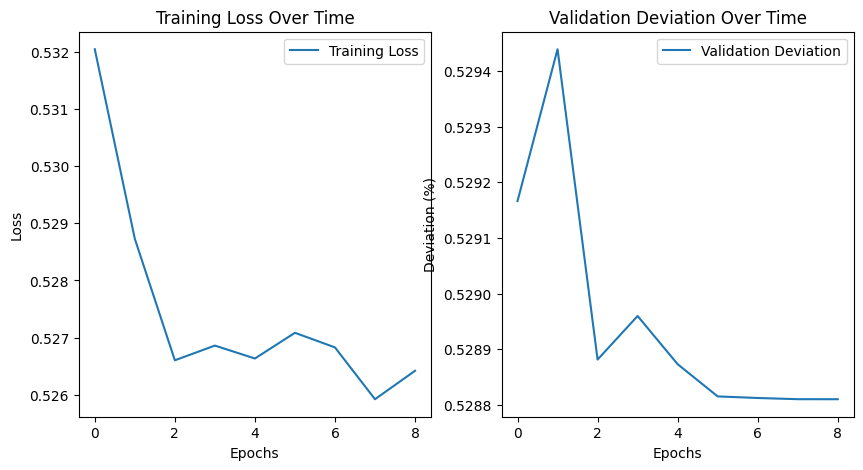

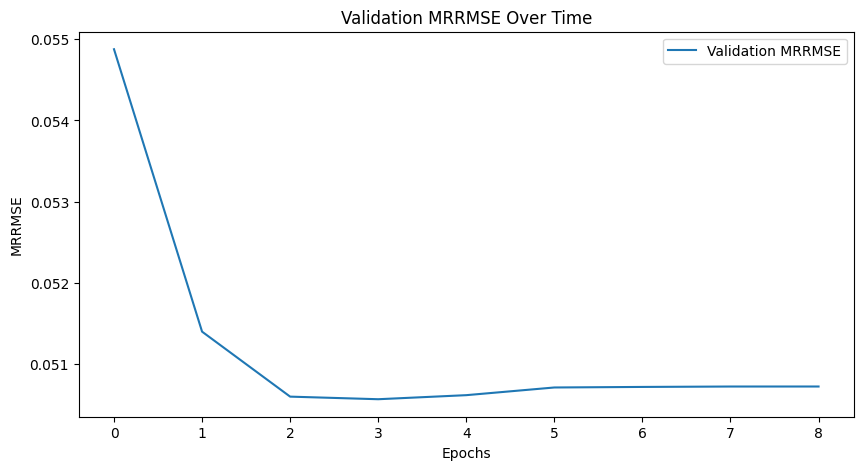

<Figure size 640x480 with 0 Axes>

In [ ]:
epoch_mrrmses = []

# Call train(epochs, batch size, layers) function
train_losses, test_losses, trained_model, epoch_mrrmses = train(20, 1, [1,1024,169])

# Now plot the loss over epochs
plt.figure(figsize=(10, 5))

# Plotting the training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

test_losses = torch.tensor(test_losses)
test_losses = test_losses.cpu()

# Plotting the deviation over epochs
plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Validation Deviation')
plt.xlabel('Epochs')
plt.ylabel('Deviation (%)')
plt.title('Validation Deviation Over Time')
plt.legend()

# Plot the MRRMSE over epochs
plt.figure(figsize=(10, 5))
plt.plot(epoch_mrrmses, label='Validation MRRMSE')
plt.xlabel('Epochs')
plt.ylabel('MRRMSE')
plt.title('Validation MRRMSE Over Time')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

In [ ]:
def hot_encode(cell, compound, device):
    # Create zero vectors for cell and compound with their respective sizes
    cell_vec = np.zeros(cell_mapping.size)
    compound_vec = np.zeros(compound_mapping.size)

    # Map cell and compound values to indices and encode
    cell_vec[{value: index for index, value in enumerate(cell_mapping)}[cell]] = 1
    compound_vec[{value: index for index, value in enumerate(compound_mapping)}[compound]] = 1

    # Concatenate the encoded vectors and convert to PyTorch tensor
    tensor = torch.from_numpy(np.concatenate((cell_vec, compound_vec), axis=0)).to(device)

    return tensor


In [ ]:
encoded_input = hot_encode("NK cells", "Clotrimazole", device)
encoded_input = encoded_input.unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions

encoded_input = encoded_input.float()

# Forward pass through the model
model_output = trained_model(encoded_input)

In [ ]:
def get_expression(cell_type, compound_name, device):
    # Encode the cell type and compound name
    encoded_input = hot_encode(cell_type, compound_name, device)

    # Reshape and convert to the correct type
    encoded_input = encoded_input.unsqueeze(0).unsqueeze(0).to(device).float()  # Add batch and channel dimensions

    # Forward pass through the model
    tensor = trained_model(encoded_input)

    # Convert the output tensor to a numpy array and unnormalize
    np_array = tensor.detach().cpu().numpy()
    df = pd.DataFrame(np_array)
    unnormalized_df = unnormalize(df, norm_min, norm_max)

    return unnormalized_df


df = get_expression("NK cells", "Clotrimazole", device)
print(df)




      0         1         2         3        4         5         6      \
0  0.277589  0.244477  0.110613  0.010069  0.40243  0.731361 -0.021193   

      7         8         9      ...     18201     18202     18203     18204  \
0  0.308377  0.032776  0.050864  ...  0.016665  0.127073  0.053731  0.202457   

     18205     18206     18207     18208     18209    18210  
0  0.36954  0.303749  0.168035  0.169966 -0.192512 -0.10958  

[1 rows x 18211 columns]


In [ ]:
# Read the sample submission and test set ID map
sample_submission = pd.read_csv("sample_submission.csv")
testDf = pd.read_csv("id_map.csv")

# Initialize a list to collect the DataFrames
predicted_values_list = []

# Loop through the test set to get the predicted values
for idx, row in testDf.iterrows():
    cell_type = row['cell_type']
    sm_name = row['sm_name']

    # Call get_expression method here
    expression_values = get_expression(cell_type, sm_name, device)

    # Append the DataFrame to the list
    predicted_values_list.append(expression_values)

# Concatenate all DataFrames in the list
predicted_values_df = pd.concat(predicted_values_list).reset_index(drop=True)

# Replace the values in the sample submission DataFrame
sample_submission.iloc[:, 1:] = predicted_values_df

# Save the DataFrame to a new CSV file
sample_submission.to_csv("my_submission.csv", index=False)

